C:\Users\anush\AppData\Local\Temp\ipykernel_13308\739516585.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Jerk'].fillna(0, inplace=True)  # Fill NaN values with 0



Fold 1:
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

       Risky       1.00      1.00      1.00      4671
    Moderate       1.00      1.00      1.00      4659
        Safe       1.00      1.00      1.00      4671

    accuracy                           1.00     14001
   macro avg       1.00      1.00      1.00     14001
weighted avg       1.00      1.00      1.00     14001



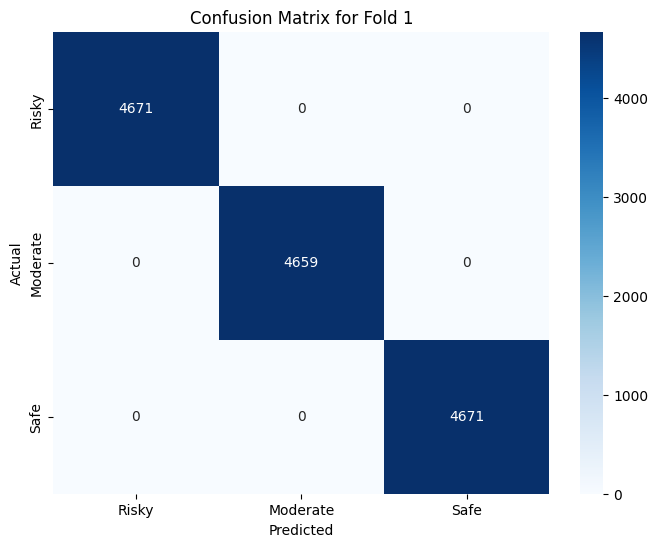


Fold 2:
Accuracy: 0.9999
Classification Report:
              precision    recall  f1-score   support

       Risky       1.00      1.00      1.00      4672
    Moderate       1.00      1.00      1.00      4659
        Safe       1.00      1.00      1.00      4670

    accuracy                           1.00     14001
   macro avg       1.00      1.00      1.00     14001
weighted avg       1.00      1.00      1.00     14001



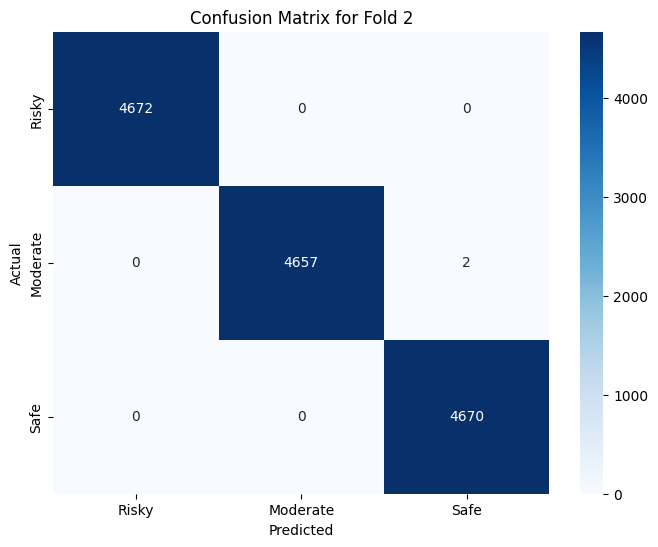


Fold 3:
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

       Risky       1.00      1.00      1.00      4672
    Moderate       1.00      1.00      1.00      4658
        Safe       1.00      1.00      1.00      4671

    accuracy                           1.00     14001
   macro avg       1.00      1.00      1.00     14001
weighted avg       1.00      1.00      1.00     14001



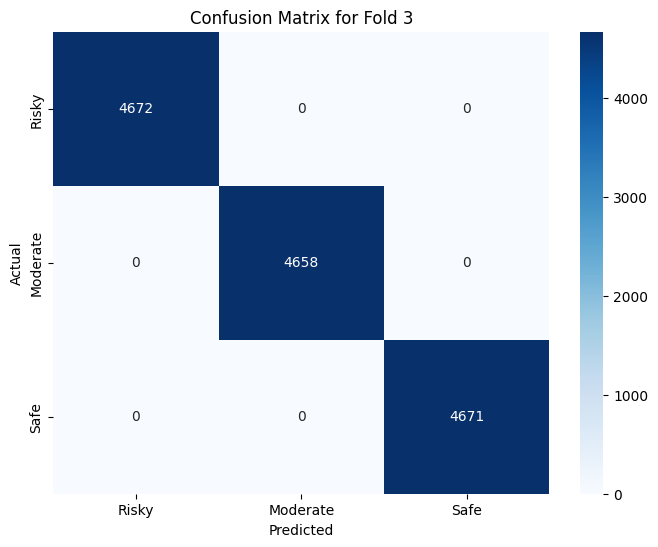


Fold 4:
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

       Risky       1.00      1.00      1.00      4671
    Moderate       1.00      1.00      1.00      4658
        Safe       1.00      1.00      1.00      4671

    accuracy                           1.00     14000
   macro avg       1.00      1.00      1.00     14000
weighted avg       1.00      1.00      1.00     14000



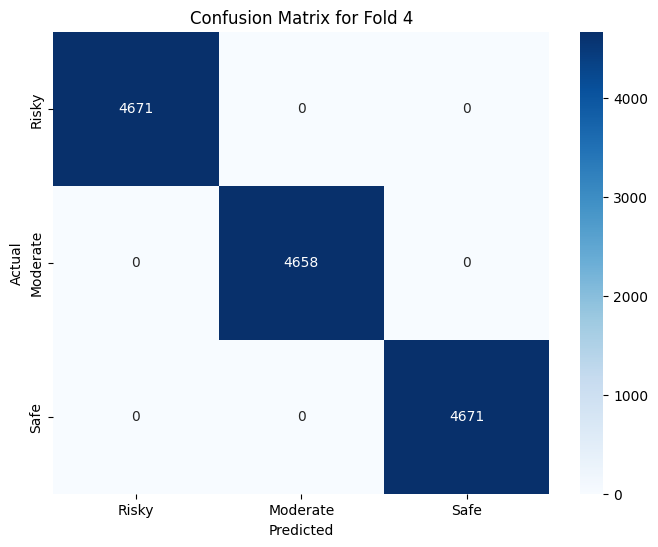


Fold 5:
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

       Risky       1.00      1.00      1.00      4671
    Moderate       1.00      1.00      1.00      4658
        Safe       1.00      1.00      1.00      4671

    accuracy                           1.00     14000
   macro avg       1.00      1.00      1.00     14000
weighted avg       1.00      1.00      1.00     14000



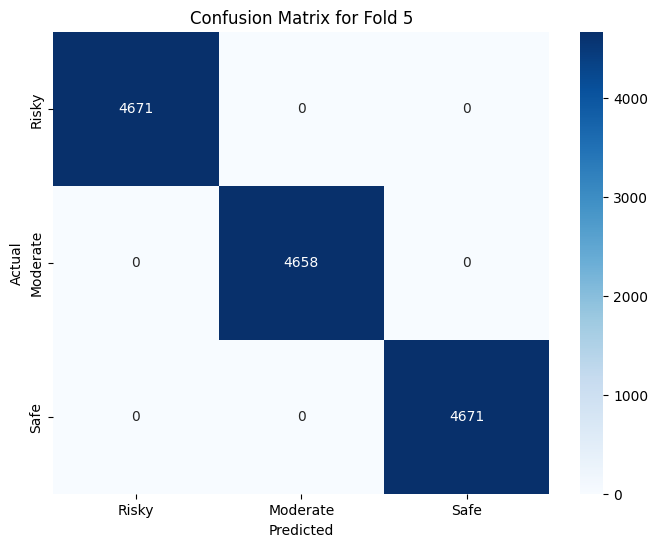


Average Validation Accuracy Across All Folds: 1.0000

Test Set Accuracy: 1.0000
Test Set Classification Report:
              precision    recall  f1-score   support

       Risky       1.00      1.00      1.00      5811
    Moderate       1.00      1.00      1.00      5876
        Safe       1.00      1.00      1.00      5814

    accuracy                           1.00     17501
   macro avg       1.00      1.00      1.00     17501
weighted avg       1.00      1.00      1.00     17501



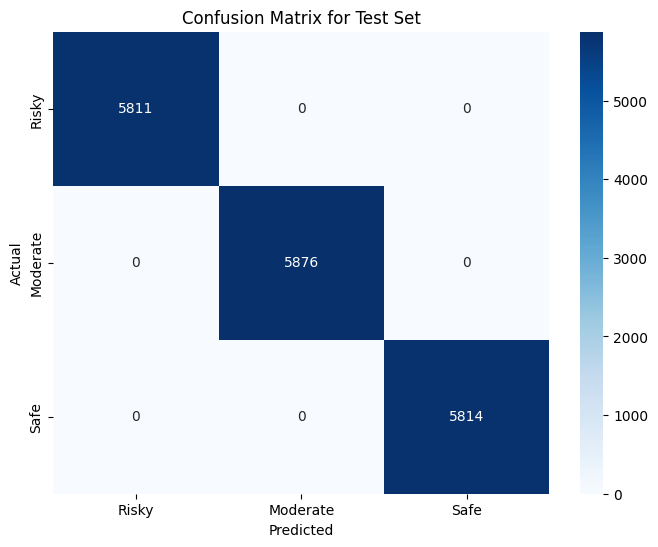

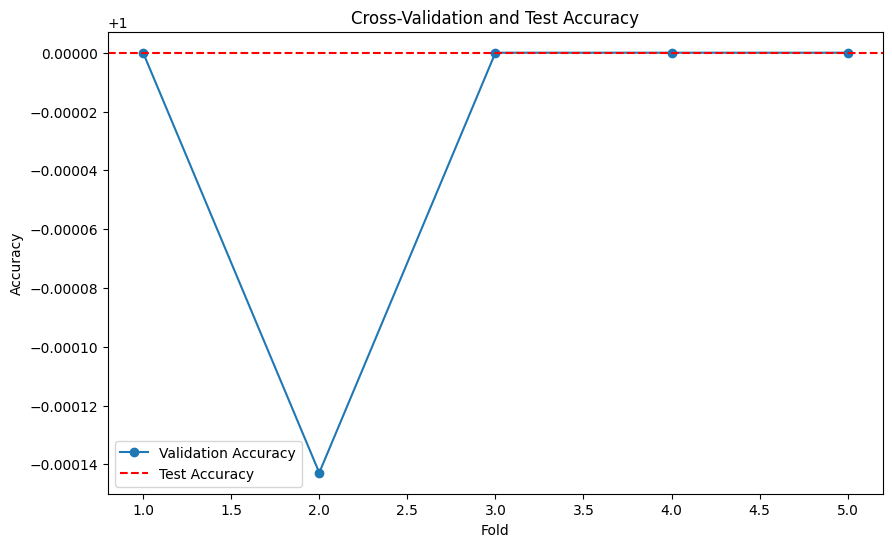

['../models/scaler_admin.pkl']

In [2]:
import os
import pandas as pd
import numpy as np
from haversine import haversine, Unit
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import joblib
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import shap
from sklearn.inspection import permutation_importance

# Load sensitive locations
sensitive_locations = pd.read_csv('../data/sensitive_location.csv')

def analyze_driving_data(df):
    """Analyzes driving data based on absolute metrics."""
    
    # Define thresholds
    speed_limit = 30  # Speed limit in km/h
    harsh_acceleration_threshold = 3.0  # Harsh acceleration in m/s^2
    harsh_braking_threshold = -3.0  # Harsh braking in m/s^2
    jerk_threshold = 5.0  # Jerk threshold in m/s^3
    heading_change_threshold = 30.0  # Heading change threshold in degrees

    # Initialize columns
    df['Jerk'] = 0.0  # Initialize Jerk column
    df['Driving_Score'] = 100  # Start with a maximum score

    # Calculate Jerk (change in acceleration over change in time)
    df['Jerk'] = df['Acceleration'].diff() / df['TimeStep'].diff()  # m/s^3
    df['Jerk'].fillna(0, inplace=True)  # Fill NaN values with 0

    # Calculate penalties based on thresholds
    df['Speed_Violation'] = np.where(df['Speed'] > speed_limit, (df['Speed'] - speed_limit) * 2, 0)
    df['Harsh_Acceleration'] = np.where(df['Acceleration'] > harsh_acceleration_threshold, (df['Acceleration'] - harsh_acceleration_threshold) * 2, 0)
    df['Harsh_Braking'] = np.where(df['Acceleration'] < harsh_braking_threshold, (harsh_braking_threshold - df['Acceleration']) * 2, 0)
    df['High_Jerk'] = np.where(abs(df['Jerk']) > jerk_threshold, abs(df['Jerk'] - jerk_threshold) * 2, 0)
    df['High_Heading_Change'] = np.where(abs(df['HeadingChange']) > heading_change_threshold, abs(df['HeadingChange'] - heading_change_threshold) * 2, 0)

    # Deduct points for violations
    df['Driving_Score'] -= df['Speed_Violation'] + df['Harsh_Acceleration'] + df['Harsh_Braking'] + df['High_Jerk'] + df['High_Heading_Change']

    # Calculate the distance to sensitive locations and check for violations
    df['Sensitive_Area_Violation'] = 0
    for index, row in df.iterrows():
        driver_location = (row['Latitude'], row['Longitude'])
        for _, loc in sensitive_locations.iterrows():
            sensitive_location = (loc['Latitude'], loc['Longitude'])
            distance = haversine(driver_location, sensitive_location, unit=Unit.METERS)
            if distance <= 300 and row['Speed'] > (speed_limit * 1000 / 3600):  # Speed limit in m/s
                df.at[index, 'Sensitive_Area_Violation'] = 1
                break  # No need to check further if one violation is found
    df['Driving_Score'] -= df['Sensitive_Area_Violation'] * 5  # Deduct points for violations near sensitive areas

    # Categorize driving behavior
    def categorize_driving(score):
        if score >= 75:
            return 'Safe'
        elif 55 <= score < 80:
            return 'Moderate'
        else:
            return 'Risky'

    df['Driving_Category'] = df['Driving_Score'].apply(categorize_driving)

    return df

# Load driving data
driving_data = pd.read_csv('../data/driving_data.csv')

# Analyze driving data
analyzed_data = analyze_driving_data(driving_data)

# Save the analyzed data for further use
analyzed_data.to_csv('../data/analyzed_driving_data.csv', index=False)

# Prepare data for model training
features = ['Speed', 'Acceleration', 'Jerk', 'High_Jerk', 'Speed_Violation', 'Harsh_Acceleration', 
            'Harsh_Braking', 'Sensitive_Area_Violation', 'High_Heading_Change']
target = 'Driving_Category'

X = analyzed_data[features]
y = analyzed_data[target]

# Convert categorical variable to numerical
y = y.map({'Safe': 2, 'Moderate': 1, 'Risky': 0})

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Train-Test split for overfitting check
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Models
rf_model = RandomForestClassifier(random_state=42)
gbc_model = GradientBoostingClassifier(random_state=42)

# Ensemble Model (Random Forest + Gradient Boosting)
ensemble_model = VotingClassifier(estimators=[
    ('rf', rf_model), ('gbc', gbc_model)], voting='soft')

# Stratified K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Convert y_train to NumPy array for indexing
y_train_np = np.array(y_train)

# K-Fold Cross-Validation
fold = 1
accuracy_scores = []

for train_index, val_index in kf.split(X_train, y_train_np):
    print(f"\nFold {fold}:")
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train_np[train_index], y_train_np[val_index]

    # Train ensemble model
    ensemble_model.fit(X_train_fold, y_train_fold)

    # Make predictions on validation set
    y_val_pred = ensemble_model.predict(X_val_fold)

    # Accuracy score
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    accuracy_scores.append(accuracy)
    print(f"Accuracy: {accuracy:.4f}")

    # Classification report
    print("Classification Report:")
    print(classification_report(y_val_fold, y_val_pred, target_names=['Risky', 'Moderate', 'Safe']))

    # Confusion matrix
    cm = confusion_matrix(y_val_fold, y_val_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Risky', 'Moderate', 'Safe'], 
                yticklabels=['Risky', 'Moderate', 'Safe'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for Fold {fold}')
    plt.show()

    fold += 1

# Average accuracy across all folds
average_accuracy = np.mean(accuracy_scores)
print(f"\nAverage Validation Accuracy Across All Folds: {average_accuracy:.4f}")

# Evaluate on Test Set
y_test_pred = ensemble_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nTest Set Accuracy: {test_accuracy:.4f}")

# Classification report on Test set
print("Test Set Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Risky', 'Moderate', 'Safe']))

# Confusion matrix for Test Set
cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Risky', 'Moderate', 'Safe'], 
            yticklabels=['Risky', 'Moderate', 'Safe'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Average accuracy plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, fold), accuracy_scores, marker='o', label='Validation Accuracy')
plt.axhline(test_accuracy, color='red', linestyle='--', label='Test Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation and Test Accuracy')
plt.legend()
plt.show()

# Save the model
joblib.dump(ensemble_model, '../models/driving_model_with_params.pkl')
joblib.dump(scaler, '../models/scaler_admin.pkl')

# ---------- Explainable AI Features ---------- #
